In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import *
#Transformers
from module import *

In [2]:
# Load training data set (small amount to test if it works first)

xtrain = r"data/training_sample_3s.csv.gz"
ytrain = r"data/training_label_3s.csv.gz"
xtest = r"data/testing_sample2_3s.csv.gz"
ytest = r"data/testing_label_3s.csv.gz"

In [3]:
#check balance
samplesdf = pd.DataFrame()
for df in  pd.read_csv(ytrain,compression ="gzip",delimiter=',', chunksize = 10000, header=0):
    samplesdf = samplesdf.append(df)
y_train = samplesdf.to_numpy()

num0 = 0
num1 = 0
for x in y_train:
    if x == 0:
        num0 = num0 + 1
    else:
        num1 = num1 + 1
num0,num1 #checking if it is balanced

(16613, 15417)

In [4]:
df = pd.read_csv(xtrain,compression ="gzip",delimiter=',', nrows=123, header=0)
x_train = df.to_numpy()
print(x_train.shape)

(123, 3148)


In [5]:
class Dataset(Dataset):

    def __init__(self,samples,labels):

        self.data = pd.read_csv(samples,compression ="gzip",delimiter=',', header=0)
        self.label = pd.read_csv(labels,compression ="gzip",delimiter=',', header=0)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        rna = self.data.iloc[idx]
        seplb = self.label.iloc[idx]
        rna = np.array([rna])
        seplb = np.array([seplb])
        rna = rna.astype('double').reshape(-1,3148)
        i = 0
        d = np.zeros((len(seplb),2))
        for x in seplb:
            if x == 0:
                d[i] = [1,0]
            else:
                d[i] = [0,1]
        sample = {'rna': rna, 'label': d}

        return sample

In [6]:
train_dataset = Dataset(samples=xtrain,labels=ytrain)
test_dataset = Dataset(samples = xtest,labels = ytest)

In [7]:
# Hyper Parameters
EPOCH = 19             # train the training data n times, to save time, we just train 1 epoch
LR = 0.0001              # learning rate
batch_size = 32
wd = LR / EPOCH

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=32, dim_hidden=128, num_heads=2, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X):
        return self.dec(self.enc(X))

In [10]:
trans = SetTransformer(3148,2,1)
optimizer = torch.optim.Adam(trans.parameters(), lr=LR)   
loss_func = nn.L1Loss()                      
if torch.cuda.is_available():
    loss_func = loss_func.cuda()
    trans = trans.cuda()
trans = trans.double()
print(trans)

SetTransformer(
  (enc): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=3148, out_features=128, bias=True)
        (fc_v): Linear(in_features=3148, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=3148, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): M

In [11]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in train_loader:
            rna,labels = batch["rna"], batch["label"] 
            if torch.cuda.is_available():
                rna = rna.cuda()
                labels = labels.cuda()
            labels = labels.reshape(-1,2)
            outputs = model(rna)
            outputs = outputs.reshape(-1,2)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
           # print(total,correct)
        TrainaccTest.append(correct/total)

        print('Train Accuracy of the model on the train rna: {} %'.format((correct / total) * 100))
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in test_loader:
            rna,labels = batch["rna"], batch["label"] 
            if torch.cuda.is_available():
                rna = rna.cuda()
                labels = labels.cuda()
            labels = labels.reshape(-1,2)
            outputs = model(rna)
            outputs = outputs.reshape(-1,2)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total,correct)
        TestaccTest.append(correct/total)

        print('Test Accuracy of the model on the test rna: {} %'.format((correct / total) * 100))



In [12]:
def train(model): 
    total_step = len(train_loader)
    num_epoch = EPOCH
    for epoch in range(num_epoch):
        model.train()
        for i, batch in enumerate(train_loader):
            # Run the forward pass
            rna,labels = batch["rna"], batch["label"] 
            if torch.cuda.is_available():
                rna = rna.cuda()
                labels = labels.cuda()
            outputs = model(rna)
            labels = labels.long()
            #print(outputs)
            outputs = outputs.reshape(-1,2)
            labels = labels.reshape(-1,2)
            loss = loss_func(outputs, labels)
            train_losses.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)
            correct = (predicted == labels).sum().item()
            train_acc.append(correct / total)
            if i % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                        .format(epoch + 1, num_epoch , i + 1, total_step, loss.item(),
                                (correct / total) * 100))
        test(model)

In [13]:
train_losses = []
train_acc = []
test_acc = []
TrainaccTest = []
TestaccTest = []
train(trans)

Epoch [1/19], Step [1/1001], Loss: 0.5037, Accuracy: 46.88%
Epoch [1/19], Step [101/1001], Loss: 0.4815, Accuracy: 59.38%
Epoch [1/19], Step [201/1001], Loss: 0.1638, Accuracy: 90.62%
Epoch [1/19], Step [301/1001], Loss: 0.2266, Accuracy: 84.38%
Epoch [1/19], Step [401/1001], Loss: 0.2179, Accuracy: 81.25%
Epoch [1/19], Step [501/1001], Loss: 0.2474, Accuracy: 75.00%
Epoch [1/19], Step [601/1001], Loss: 0.2132, Accuracy: 81.25%
Epoch [1/19], Step [701/1001], Loss: 0.2522, Accuracy: 75.00%
Epoch [1/19], Step [801/1001], Loss: 0.2353, Accuracy: 78.12%
Epoch [1/19], Step [901/1001], Loss: 0.2901, Accuracy: 71.88%
Epoch [1/19], Step [1001/1001], Loss: 0.2256, Accuracy: 80.00%
Train Accuracy of the model on the train rna: 82.85669684670621 %
Test Accuracy of the model on the test rna: 78.71022247254295 %
Epoch [2/19], Step [1/1001], Loss: 0.2395, Accuracy: 78.12%
Epoch [2/19], Step [101/1001], Loss: 0.1650, Accuracy: 87.50%
Epoch [2/19], Step [201/1001], Loss: 0.1799, Accuracy: 87.50%
Epoch

Epoch [11/19], Step [201/1001], Loss: 0.1632, Accuracy: 81.25%
Epoch [11/19], Step [301/1001], Loss: 0.0946, Accuracy: 90.62%
Epoch [11/19], Step [401/1001], Loss: 0.1020, Accuracy: 90.62%
Epoch [11/19], Step [501/1001], Loss: 0.0797, Accuracy: 93.75%
Epoch [11/19], Step [601/1001], Loss: 0.1324, Accuracy: 87.50%
Epoch [11/19], Step [701/1001], Loss: 0.0224, Accuracy: 100.00%
Epoch [11/19], Step [801/1001], Loss: 0.1033, Accuracy: 90.62%
Epoch [11/19], Step [901/1001], Loss: 0.0682, Accuracy: 93.75%
Epoch [11/19], Step [1001/1001], Loss: 0.1308, Accuracy: 86.67%
Train Accuracy of the model on the train rna: 91.91070871058383 %
Test Accuracy of the model on the test rna: 83.83553928470853 %
Epoch [12/19], Step [1/1001], Loss: 0.1078, Accuracy: 90.62%
Epoch [12/19], Step [101/1001], Loss: 0.0067, Accuracy: 100.00%
Epoch [12/19], Step [201/1001], Loss: 0.0765, Accuracy: 93.75%
Epoch [12/19], Step [301/1001], Loss: 0.0744, Accuracy: 93.75%
Epoch [12/19], Step [401/1001], Loss: 0.1485, Accu

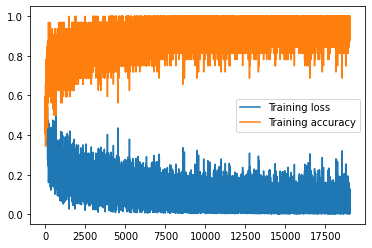

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(train_acc, label='Training accuracy')
plt.legend()
plt.show()

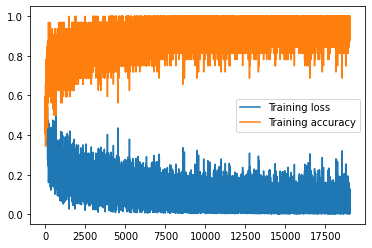

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(train_acc, label='Training accuracy')
plt.legend()
plt.show()

torch.Size([3551, 3148])
torch.Size([3551, 1])
tensor([[ 0.9989, -0.0053],
        [ 1.0023, -0.0028],
        [ 0.0093,  1.0020],
        ...,
        [ 0.9999, -0.0057],
        [ 0.0089,  1.0011],
        [ 0.9989, -0.0040]], dtype=torch.float64)


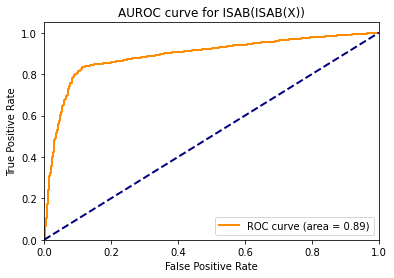

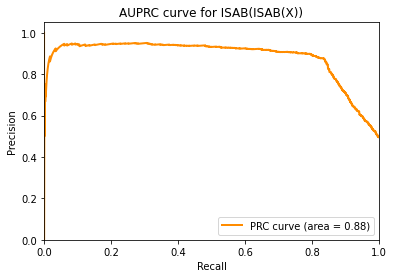

AUPRC = 0.88
f1_score = 0.85


In [17]:
samplesdf = pd.DataFrame()
samplesdf = pd.read_csv(xtest,compression ="gzip",delimiter=',',header=0)
x_test = samplesdf.to_numpy()

samplesdf = pd.DataFrame()
samplesdf = pd.read_csv(ytest,compression ="gzip",delimiter=',', header=0)
y_test = samplesdf.to_numpy()

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
print(x_test.shape)
print(y_test.shape)
with torch.no_grad():
    trans.eval()
    trans = trans.cpu()

    x_test = x_test.reshape(-1,1,3148)
    outputs = trans(x_test)
    out = outputs.data.reshape(-1,2)
    print(out)
    predicted = np.zeros((len(out)))
    i = 0
    for x in out:
        predicted[i] = x[1]
        i = i + 1
    y_test = y_test.cpu()
    y_test = y_test.reshape(-1)
    fpr, tpr, _ = roc_curve(y_test,predicted)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr,tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC curve for ISAB(ISAB(X))')
    plt.legend(loc="lower right")
    plt.show()
    precision, recall, _ = precision_recall_curve(y_test,predicted)
    prc_auc = auc(recall,precision)
    plt.plot(recall,precision, color='darkorange',
             lw=lw, label='PRC curve (area = %0.2f)' % prc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('AUPRC curve for ISAB(ISAB(X))')
    plt.legend(loc="lower right")
    plt.show()
    print("AUPRC = %.02f"% prc_auc)
    ss = np.zeros((len(predicted)))
    i = 0
    for x in predicted:
        if x >= 0.5:
            ss[i] = 1
        else:
            ss[i] = 0
        i = i + 1
    f1s = f1_score(y_test,ss)
    print("f1_score = %.02f"% f1s)
    df = pd.DataFrame(y_test)
    df.to_csv(r"data/isabisablb3.csv.gz",index=False,sep=",",compression="gzip")
    df = pd.DataFrame(predicted)
    df.to_csv(r"data/isabisabpredict3.csv.gz",index=False,sep=",",compression="gzip")
